In [1]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


import pickle


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt


import warnings
warnings.simplefilter('ignore')

PyTorch version: 1.13.1+cu117
Using device: cuda:0


# Synthetic data

Open some standard training data

In [2]:
mouse_id = 'Mouse12'
session_id = 120806
phase = 'wake'
subset = 'hdc'
bin_size = 160
single_spikes = False

data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)

units:  85  hdc units:  22


### Create a synthetic dataset with neurons with Gaussian-like head direction tuning curves and Poisson SCDs.

In [3]:
T = dataset_dict['tbin']

def rate(s, s_preffered = np.pi, sigma=1, r_max = 10):
    """Rate tuning curve will look like a Gaussian"""
    return r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma**2) + 20

def rate_circular(s, s_preffered = np.pi, sigma=np.pi/4, r_max = 10):
    """Rate tuning curve will look like circular wrapped Gaussian"""
    sum = 0
    for k in [-1,0,1]:
        sum += np.exp(-0.5 * (s - s_preffered + 2*np.pi*k)**2 / sigma**2)
    return r_max * sum + 20


In [53]:
synthetic_data = dataset_dict.copy()
synthetic_data['name'] = 'synthetic-poisson'

time = dataset_dict['covariates']['time']
time2 = np.concatenate((time, np.arange(1, dataset_dict['timesamples']+1)*dt*10e-3 + time[-1]))

hd = dataset_dict['covariates']['hd']
hd2 = np.concatenate((hd, hd[::-1]))

synthetic_data['covariates'] = {'hd': hd2,
                                'time': time2}
synthetic_data['spiketrains'] = []
synthetic_data['timesamples'] = time2.size

hd = synthetic_data['covariates']['hd']

r_max=50
neurons = 5
preferred_directions = np.linspace(0, 2*np.pi, neurons)
for n in range(neurons):
    spiketrain = []
    for t in range(synthetic_data['timesamples']):
        r_t = rate_circular(hd[t], s_preffered=preferred_directions[n], r_max=r_max)
        spiketrain.append(np.random.poisson(lam=r_t*T))
    synthetic_data['spiketrains'].append(spiketrain)
max_count = np.max(synthetic_data['spiketrains'])

synthetic_data['spiketrains'] = np.array(synthetic_data['spiketrains'])
synthetic_data['max_count'] = max_count
synthetic_data['neurons'] = neurons

In [54]:
np.savez_compressed(data_dir+'/synthetic_poisson', name=synthetic_data['name'],
                    covariates = synthetic_data['covariates'],
                    spiketrains = synthetic_data['spiketrains'],
                    neurons = synthetic_data['neurons'],
                    metainfo = synthetic_data['metainfo'],
                    tbin = synthetic_data['tbin'],
                    timesamples = synthetic_data['timesamples'],
                    max_count = synthetic_data['max_count'],
                    bin_size = synthetic_data['bin_size'])

In [55]:
data = HDC.get_synthetic_data('synthetic_poisson', data_dir)

### Recover tuning curves through histograms

Text(0, 0.5, 'Firing rate [Hz]')

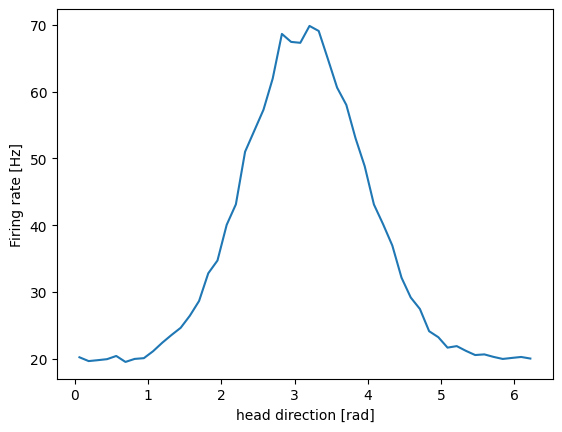

In [56]:
ne = 2

hist, bin_edges = np.histogram(hd, bins = 50)

mean_tc = []
for i in range(len(bin_edges) - 1):
    indexes = np.where(np.logical_and(hd >= bin_edges[i], hd < bin_edges[i+1]))
    mean = np.array(synthetic_data['spiketrains'][ne])[indexes].mean()
    mean_tc.append(mean)

mean_tc = np.array(mean_tc)
plt.plot((bin_edges[1:] + bin_edges[:-1])/2, mean_tc/synthetic_data['tbin'])
plt.xlabel('head direction [rad]')
plt.ylabel('Firing rate [Hz]')


# Data with non-Poisson Fisher curve

Here we construct a neuron which has a mean firing rate response $f(s)$ as above (Gaussian-like with a preferred orientation), and has uneven Fano factor (i.e. non-Poisson neuron). We do this by defining an interval $[l,r]$ such that for stimuli outside the interval ($s < l$ or  $s > r$) neuron has Poisson SCDs $p(y|s) = \textup{Gaussian}(y; f(s), \sigma^2)$, and for stimuli inside the interval ($l \leq s \leq r$) neuron has a Uniform SCD $p(y|s) = \mathcal{U} (y; 0, 2*f(s))$. This should keep the mean response of such neuron to $f(s)$.

In [34]:
synthetic_data = dataset_dict.copy()
synthetic_data['name'] = 'synthetic-nonpoisson'
time = dataset_dict['covariates']['time']
dt = dataset_dict['bin_size']
time2 = np.concatenate((time, np.arange(1, dataset_dict['timesamples']+1)*dt*10e-3 + time[-1]))

hd = dataset_dict['covariates']['hd']
hd2 = np.concatenate((hd, hd[::-1]))

synthetic_data['covariates'] = {'hd': hd2,
                                'time': time2}
synthetic_data['spiketrains'] = []
synthetic_data['timesamples'] = time2.size

hd = synthetic_data['covariates']['hd']

r_max = 50
neurons = 5
preferred_directions = np.linspace(0, 2*np.pi, neurons)
l = preferred_directions - np.pi/2
l[np.where(l < 0)] += 2*np.pi
r = preferred_directions + np.pi/2
r[np.where(r > 2*np.pi)] -= 2*np.pi
uniform_r = r_max/5

for n in range(neurons):
    spiketrain = []
    for t in range(synthetic_data['timesamples']):
        r_t = rate_circular(hd[t], s_preffered=preferred_directions[n], r_max=r_max, sigma=1)
        if (l[n] < r[n] and hd[t] > l[n] and hd[t] < r[n]) or (r[n] < l[n] and (hd[t] > l[n] or hd[t] < r[n])):
            spiketrain.append(np.random.randint(low=0, high=round(2*r_t*T)+1))
        else:            
            spiketrain.append(round(np.random.normal(loc=r_t, scale=10)*T))


    synthetic_data['spiketrains'].append(spiketrain)
max_count = np.max(synthetic_data['spiketrains'])

synthetic_data['spiketrains'] = np.array(synthetic_data['spiketrains'])
synthetic_data['max_count'] = max_count
synthetic_data['neurons'] = neurons

In [35]:
np.savez_compressed(data_dir+'/synthetic_nonpoisson', name=synthetic_data['name'],
                    covariates = synthetic_data['covariates'],
                    spiketrains = synthetic_data['spiketrains'],
                    neurons = synthetic_data['neurons'],
                    metainfo = synthetic_data['metainfo'],
                    tbin = synthetic_data['tbin'],
                    timesamples = synthetic_data['timesamples'],
                    max_count = synthetic_data['max_count'],
                    bin_size = synthetic_data['bin_size'])

Text(0, 0.5, 'Firing rate [Hz]')

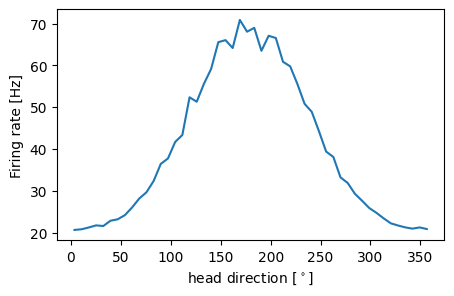

In [36]:
ne = 2

hist, bin_edges = np.histogram(hd, bins = 50)

mean_tc = []
for i in range(len(bin_edges) - 1):
    indexes = np.where(np.logical_and(hd >= bin_edges[i], hd < bin_edges[i+1]))
    mean = np.array(synthetic_data['spiketrains'][ne])[indexes].mean()
    mean_tc.append(mean)

mean_tc = np.array(mean_tc)

fig, ax = plt.subplots(figsize=(5,3))

ax.plot(180/np.pi*(bin_edges[1:] + bin_edges[:-1])/2, mean_tc/synthetic_data['tbin'])
ax.set_xlabel('head direction [$^\circ$]')
ax.set_ylabel('Firing rate [Hz]')

# Data with Uniform SCD

In [60]:
synthetic_data = dataset_dict.copy()
synthetic_data['name'] = 'synthetic-uniform'
time = dataset_dict['covariates']['time']
time2 = np.concatenate((time, np.arange(1, dataset_dict['timesamples']+1)*dt*10e-3 + time[-1]))

hd = dataset_dict['covariates']['hd']
hd2 = np.concatenate((hd, hd[::-1]))

synthetic_data['covariates'] = {'hd': hd2,
                                'time': time2}
synthetic_data['spiketrains'] = []
synthetic_data['timesamples'] = time2.size

hd = synthetic_data['covariates']['hd']

r_max = 50
neurons = 5
preferred_directions = np.linspace(0, 2*np.pi, neurons)

for n in range(neurons):
    spiketrain = []
    for t in range(synthetic_data['timesamples']):
        r_t = rate_circular(hd[t], s_preffered=preferred_directions[n], r_max=r_max, sigma=1)
        spiketrain.append(np.random.randint(low=0, high=round(2*r_t*T)+1))


    synthetic_data['spiketrains'].append(spiketrain)
max_count = np.max(synthetic_data['spiketrains'])

synthetic_data['spiketrains'] = np.array(synthetic_data['spiketrains'])
synthetic_data['max_count'] = max_count
synthetic_data['neurons'] = neurons

Text(0, 0.5, 'Firing rate [Hz]')

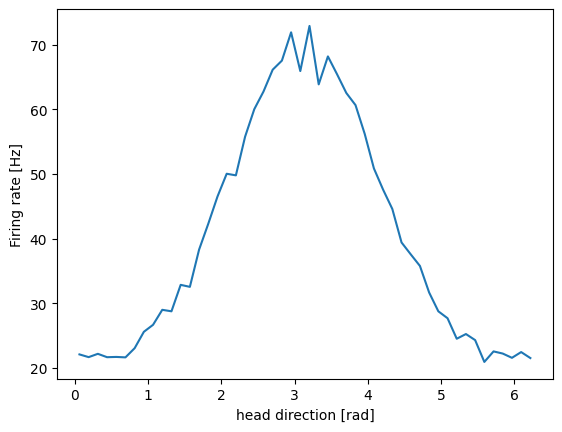

In [61]:
ne = 2

hist, bin_edges = np.histogram(hd, bins = 50)

mean_tc = []
for i in range(len(bin_edges) - 1):
    indexes = np.where(np.logical_and(hd >= bin_edges[i], hd < bin_edges[i+1]))
    mean = np.array(synthetic_data['spiketrains'][ne])[indexes].mean()
    mean_tc.append(mean)

mean_tc = np.array(mean_tc)
plt.plot((bin_edges[1:] + bin_edges[:-1])/2, mean_tc/synthetic_data['tbin'])
plt.xlabel('head direction [rad]')
plt.ylabel('Firing rate [Hz]')

In [62]:
np.savez_compressed(data_dir+'/synthetic_uniform', name=synthetic_data['name'],
                    covariates = synthetic_data['covariates'],
                    spiketrains = synthetic_data['spiketrains'],
                    neurons = synthetic_data['neurons'],
                    metainfo = synthetic_data['metainfo'],
                    tbin = synthetic_data['tbin'],
                    timesamples = synthetic_data['timesamples'],
                    max_count = synthetic_data['max_count'],
                    bin_size = synthetic_data['bin_size'])

# Non-Poisson 2

In [5]:
synthetic_data = dataset_dict.copy()
synthetic_data['name'] = 'synthetic-nonpoisson-2'
time = dataset_dict['covariates']['time']
dt = dataset_dict['bin_size']
time2 = np.concatenate((time, np.arange(1, dataset_dict['timesamples']+1)*dt*10e-3 + time[-1]))

hd = dataset_dict['covariates']['hd']
hd2 = np.concatenate((hd, hd[::-1]))

synthetic_data['covariates'] = {'hd': hd2,
                                'time': time2}
synthetic_data['spiketrains'] = []
synthetic_data['timesamples'] = time2.size

hd = synthetic_data['covariates']['hd']

r_max = 50
neurons = 5
preferred_directions = np.linspace(0, 2*np.pi, neurons)

for n in range(neurons):
    spiketrain = []
    for t in range(synthetic_data['timesamples']):
        r_t = rate_circular(hd[t], s_preffered=preferred_directions[n], r_max=r_max, sigma=1)
        if hd[t] < preferred_directions[n]:
            spiketrain.append(np.random.randint(low=0, high=round(2*r_t*T)+1))
        else:            
            spiketrain.append(round(np.random.normal(loc=r_t, scale=10)*T))


    synthetic_data['spiketrains'].append(spiketrain)
max_count = np.max(synthetic_data['spiketrains'])

synthetic_data['spiketrains'] = np.array(synthetic_data['spiketrains'])
synthetic_data['max_count'] = max_count
synthetic_data['neurons'] = neurons

Text(0, 0.5, 'Firing rate [Hz]')

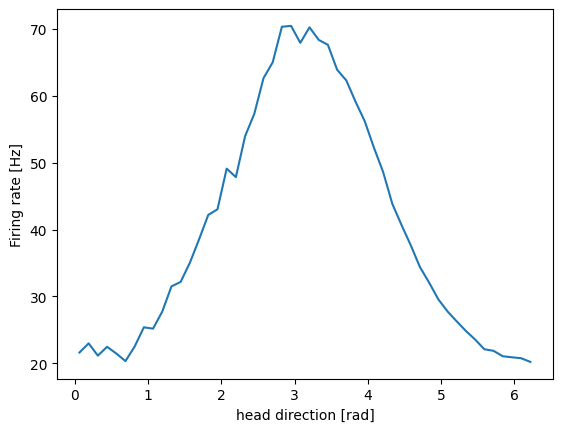

In [6]:
ne = 2

hist, bin_edges = np.histogram(hd, bins = 50)

mean_tc = []
for i in range(len(bin_edges) - 1):
    indexes = np.where(np.logical_and(hd >= bin_edges[i], hd < bin_edges[i+1]))
    mean = np.array(synthetic_data['spiketrains'][ne])[indexes].mean()
    mean_tc.append(mean)

mean_tc = np.array(mean_tc)
plt.plot((bin_edges[1:] + bin_edges[:-1])/2, mean_tc/synthetic_data['tbin'])
plt.xlabel('head direction [rad]')
plt.ylabel('Firing rate [Hz]')

In [7]:
np.savez_compressed(data_dir+'/synthetic_nonpoisson_2', name=synthetic_data['name'],
                    covariates = synthetic_data['covariates'],
                    spiketrains = synthetic_data['spiketrains'],
                    neurons = synthetic_data['neurons'],
                    metainfo = synthetic_data['metainfo'],
                    tbin = synthetic_data['tbin'],
                    timesamples = synthetic_data['timesamples'],
                    max_count = synthetic_data['max_count'],
                    bin_size = synthetic_data['bin_size'])

# Negative binomial

In [4]:
import scipy.stats

Text(0, 0.5, 'Firing rate [Hz]')

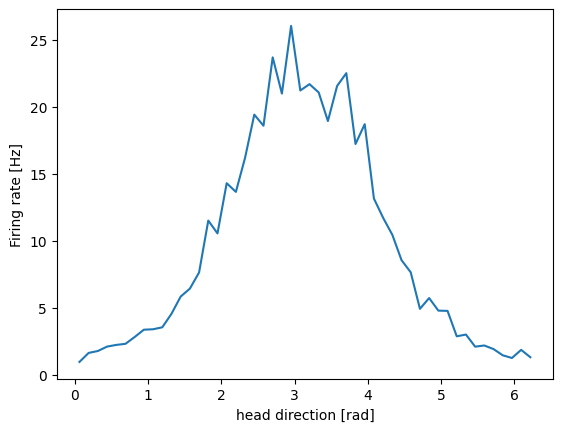

In [24]:
synthetic_data = dataset_dict.copy()
synthetic_data['name'] = 'synthetic-negative-binomial'
time = dataset_dict['covariates']['time']
dt = dataset_dict['bin_size']
time2 = np.concatenate((time, np.arange(1, dataset_dict['timesamples']+1)*dt*10e-3 + time[-1]))

hd = dataset_dict['covariates']['hd']
hd2 = np.concatenate((hd, hd[::-1]))

synthetic_data['covariates'] = {'hd': hd2,
                                'time': time2}
synthetic_data['spiketrains'] = []
synthetic_data['timesamples'] = time2.size

hd = synthetic_data['covariates']['hd']

r_max = 20
neurons = 5
preferred_directions = np.linspace(np.pi/3, 5*np.pi/3, neurons)


def mean_nbim(s, s_preffered = np.pi, sigma=1, r_max=10): 
    return (r_max * np.exp(-0.5 * (s - s_preffered)**2 / sigma**2) + 1)*dt*1e-3



def ff_nbim(s, s_preffered = np.pi, sigma=1, r_max=10):
    return 50*(np.exp(-0.5 * (s - s_preffered)**2 / sigma**2) * (- (s-s_preffered)/ sigma**2) )**2 + 5

for n in range(neurons):
    spiketrain = []
    for t in range(synthetic_data['timesamples']):
        m_t = mean_nbim(hd[t], s_preffered=preferred_directions[n], sigma=1, r_max=r_max)
        var_t = ff_nbim(hd[t], s_preffered=preferred_directions[n], sigma=1, r_max=r_max) * m_t

        param_p = m_t / var_t
        param_n = m_t**2 / (var_t - m_t)
        spiketrain.append(scipy.stats.nbinom.rvs(param_n, param_p))

    synthetic_data['spiketrains'].append(spiketrain)
max_count = np.max(synthetic_data['spiketrains'])

synthetic_data['spiketrains'] = np.array(synthetic_data['spiketrains'])
synthetic_data['max_count'] = max_count
synthetic_data['neurons'] = neurons

ne = 2

hist, bin_edges = np.histogram(hd, bins = 50)

mean_tc = []
for i in range(len(bin_edges) - 1):
    indexes = np.where(np.logical_and(hd >= bin_edges[i], hd < bin_edges[i+1]))
    mean = np.array(synthetic_data['spiketrains'][ne])[indexes].mean()
    mean_tc.append(mean)

mean_tc = np.array(mean_tc)
plt.plot((bin_edges[1:] + bin_edges[:-1])/2, mean_tc/synthetic_data['tbin'])
plt.xlabel('head direction [rad]')
plt.ylabel('Firing rate [Hz]')

In [16]:
np.savez_compressed(data_dir+'/synthetic_negbinomial', name=synthetic_data['name'],
                    covariates = synthetic_data['covariates'],
                    spiketrains = synthetic_data['spiketrains'],
                    neurons = synthetic_data['neurons'],
                    metainfo = synthetic_data['metainfo'],
                    tbin = synthetic_data['tbin'],
                    timesamples = synthetic_data['timesamples'],
                    max_count = synthetic_data['max_count'],
                    bin_size = synthetic_data['bin_size'])

50 0.16


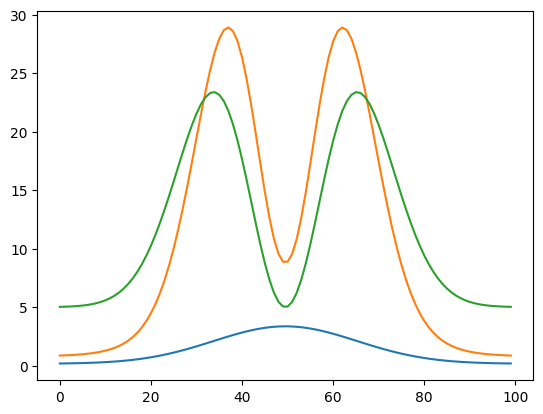

In [23]:
m = []
f = []
v = []

print(r_max, dt*1e-3)

for s in np.linspace(0, 2*np.pi, 100):
    m.append(mean_nbim(s, r_max=20))
    f.append(ff_nbim(s))
    v.append(ff_nbim(s)*mean_nbim(s))

plt.plot(m)
plt.plot(v)
plt.plot(f)